<img src='http://de-bug.de/medien/files/uploads/2009/01/image-eigenfaces.png' width=250>

Цель задачи – построить классификатор лиц без нейронных сетей и на основе базы небольшого числа фотографий: в датасете фотографии 40 человек, по 10 фотографий каждого.

- Возьму первые 9 фотографий каждого лица (всего $360$ изображений). Представим эти фотографии как матрицу $F$ с $9\times 40$ столбцами, каждый из которых содержит одну фотографию, вытянутую в вектор.  
  
- Вычислю и нарисую усреднённое лицо. Вычту его из каждого столбца матрицы $F$. Обозначим получившуюся матрицу $\hat{F}$

- Возьмём SVD от матрицы $\hat{F}$ и построим её малоранговую аппроксимацию: $\hat{F}_r = U_r S_r V_r^{\top}$. 

Матрица $U_r$ с $r$ столбцами – базис в пространстве лиц. $W_r = S_r V_r^{\top}$ матрица коэффициентов в этом базисе. Теперь каждое изображение можно представить как небольшое число коэффициентов разложения по этому базису.
 
- Преобразуйте первые k столбцов матрицы $U_r$ в матрицы и нарисуйте их  - это "eigenfaces".

- Возьму тестовую выборку из остальных фотографий. Найду коэффициенты, с которыми их можно разложить в базисе $U_r$. Для этого нужно спроецирую фотографии из тестовой выборки на столбцы $U_r$. 

- Сравню полученные векторы коэффициентов с векторами в матрице $W_r$ при помощи Cosine_similarity, и классифицирую тестовые изображения. Посмотрю на неправильно классифицированные фотографии при $r=5$.

In [3]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from numpy.linalg import svd
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline


train = []
for i in range(1, 41):
    for j in range(1, 10):
        img = imageio.imread('orl_faces/s{}/{}.pgm'.format(i, j))
        train.append(img.reshape(-1, 1))
train = np.hstack(train).astype(float)
train.shape

(10304, 360)

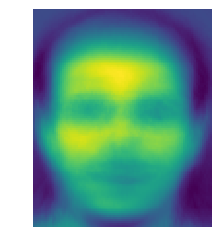

In [4]:
train_face = train.mean(axis=1)
plt.figure()
plt.imshow(train_face.reshape(112, 92))
plt.axis('off')

F = train - train_face[:, np.newaxis]

In [5]:
#вычисляю SVD-разложение
U, S, V = svd(F)
print(S[0], S[1], S[2], S[3], S[4])

r = 5
#малоранговая аппроксимация F_r = U_r*S_r*V_r 

U_r = U[:, 0:r]

S_r = np.zeros((r, r))
for i in range(r):
    S_r[i, i] = S[i]

V_r = V[0:r, :]

W_r = np.dot(S_r, V_r)

F_r = np.dot(U_r, np.dot(S_r, V_r))

print(U_r.shape, S_r.shape, V_r.shape, F_r.shape)

32101.263465396347 27083.953202982557 19900.965311101198 18023.186655045993 17023.51070997996
(10304, 5) (5, 5) (5, 360) (10304, 360)


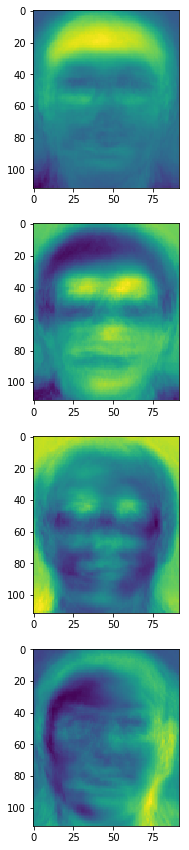

In [6]:
F1 = U_r[:, 0].reshape((112, 92))
F2 = U_r[:, 1].reshape((112, 92))
F3 = U_r[:, 2].reshape((112, 92))
F4 = U_r[:, 3].reshape((112, 92))

fig = plt.subplots(4, 1, figsize=(10, 15))
plt.subplot(4, 1, 1)
plt.imshow(F1)
plt.subplot(4, 1, 2)
plt.imshow(F2)
plt.subplot(4, 1, 3)
plt.imshow(F3)
plt.subplot(4, 1, 4)
plt.imshow(F4)

plt.show() 

In [7]:
test = []
for i in range(1, 41):
    img = imageio.imread('orl_faces/s{}/{}.pgm'.format(i, 10))
    test.append(img.reshape(-1, 1))
test = np.hstack(test).astype(float)

test_face = test.mean(axis=1)
test = test - test_face[:, np.newaxis]
#Столбцы U_r - ортонормированы, поэтому коэффициентами разложения вектора из теста является просто скалярное произведение
#вычисляю скалярне произведения (коэффициенты в базисе U_r[0],.., U_r[r-1]) сразу для каждого вектора из теста
test_coeff = np.dot(test.T, U_r).T
print(test_coeff.shape, W_r.shape)

(5, 40) (5, 360)


In [8]:
#нахожу ближайшую фотографию в train-е и определяю человека по ней
results1 = []
for i in range(40):
    similarity_i = np.empty(360)
    for j in range(360):
        similarity_i[j] = cosine_similarity(test_coeff[:, i][np.newaxis, :], W_r[:, j][np.newaxis, :])
    cls = np.argmax(similarity_i)
    results1.append((i, (cls) // 9))
score1 = sum([(i[0] == i[1]) for i in results1])
print(f'r = {r}\t score1 = {score1}')
for i in results1:
    if i[0] != i[1]:
        print(i[0])

r = 5	 score1 = 32
1
9
15
17
18
26
34
35


In [9]:
#усредняю результаты расстояние по 9 фотографиям каждого человека и беру человека с самым высоким средним
results2 = []
for i in range(40):
    similarity_i = np.empty(360)
    for j in range(360):
        similarity_i[j] = cosine_similarity(test_coeff[:, i][np.newaxis, :], W_r[:, j][np.newaxis, :])
    cls = np.argmax(similarity_i.reshape(40, 9).mean(axis=1))    
    results2.append((i, cls))
results2
score2 = sum([(i[0] == i[1]) for i in results2])
print(f'r = {r}\t score2 = {score2}')
for i in results2:
    if i[0] != i[1]:
        print(i[0])

r = 5	 score2 = 21
1
2
3
4
9
14
15
16
19
22
24
27
28
30
31
34
35
36
39


Простое 1nn показало лучшую точность (32 против 21).